In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import feature_column

from IPython.display import clear_output


In [ ]:
#names of the columns
col_names = ['ID', 'Age', 'Gender', 'TB', 'DB', 'ALK', 'SGPT', 'SGOT', 'TP', 'ALB', 'AG_Ratio', 'Class']

#uploading the files
training_set = pd.read_csv("training.csv", header=None, names = col_names)
testing_set = pd.read_csv("testing.csv", header=None, names = col_names)

#removing the ID column
training_set.pop('ID')
testing_set.pop('ID')

training_set.head()

,Age,Gender,TB,DB,ALK,SGPT,SGOT,TP,ALB,AG_Ratio,Class
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.9,Yes
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,Yes
2,62,Male,7.3,4.1,490,60,68,7,3.3,0.89,Yes
3,58,Male,1,0.4,182,14,20,6.8,3.4,1,Yes
4,72,Male,3.9,2,195,27,59,7.3,2.4,0.4,Yes


In [ ]:
training_set.dtypes

Age          int64
Gender      object
TB          object
DB          object
ALK         object
SGPT        object
SGOT        object
TP          object
ALB         object
AG_Ratio    object
Class       object
dtype: object

In [ ]:
#converting the features Class and Gender to categorical data (0,1)
training_set['Class'] = pd.Categorical(training_set['Class'])
training_set['Class'] = training_set.Class.cat.codes
testing_set['Class'] = pd.Categorical(testing_set['Class'])
testing_set['Class'] = testing_set.Class.cat.codes

training_set['Gender'] = pd.Categorical(training_set['Gender'])
training_set['Gender'] = training_set.Gender.cat.codes
testing_set['Gender'] = pd.Categorical(testing_set['Gender'])
testing_set['Gender'] = testing_set.Gender.cat.codes

#to replace the ? values with mode
from sklearn.impute import SimpleImputer

training_set.replace('?',np.NaN,inplace=True)
testing_set.replace('?',np.NaN,inplace=True)

imp = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

itraining_set = pd.DataFrame(imp.fit_transform(training_set))
itraining_set.columns = training_set.columns
itraining_set.index = training_set.index

itesting_set = pd.DataFrame(imp.fit_transform(testing_set))
itesting_set.columns=testing_set.columns
itesting_set.index=testing_set.index

print(itesting_set['Class'])

0      1
1      1
2      1
3      1
4      1
      ..
306    1
307    1
308    1
309    1
310    1
Name: Class, Length: 311, dtype: object


In [ ]:
itraining_set.dtypes

Age         object
Gender      object
TB          object
DB          object
ALK         object
SGPT        object
SGOT        object
TP          object
ALB         object
AG_Ratio    object
Class       object
dtype: object

In [ ]:

integer_set = ['Age', 'Gender', 'ALK', 'SGPT', 'SGOT', 'Class']
float_set = ['TB', 'DB', 'TP', 'ALB', 'AG_Ratio']

#since the data types are object. we need to convert them to integer and float accordingly

for i in integer_set:
  itraining_set[i] = tf.convert_to_tensor(itraining_set[i],dtype=tf.int32)
  itesting_set[i] = tf.convert_to_tensor(itesting_set[i],dtype=tf.int32)

for i in float_set:
  itraining_set[i] = tf.convert_to_tensor(itraining_set[i],dtype=tf.float32)
  itesting_set[i] = tf.convert_to_tensor(itesting_set[i],dtype=tf.float32)

itraining_set.head()


,Age,Gender,TB,DB,ALK,SGPT,SGOT,TP,ALB,AG_Ratio,Class
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [ ]:
itraining_set[itraining_set.columns[0:]].corr()['Class'][:]

Age         0.137351
Gender      0.082416
TB          0.220228
DB          0.244106
ALK         0.184090
SGPT        0.163308
SGOT        0.151861
TP         -0.032244
ALB        -0.164992
AG_Ratio   -0.162403
Class       1.000000
Name: Class, dtype: float64

In [ ]:
#removing the target variable 
itraining_set_y = itraining_set.pop('Class')
itesting_set_y = itesting_set.pop('Class')

In [ ]:
itraining_set.dtypes
itraining_set.head()

,Age,Gender,TB,DB,ALK,SGPT,SGOT,TP,ALB,AG_Ratio
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40


In [ ]:
itraining_set_y.head()

0    1
1    1
2    1
3    1
4    1
Name: Class, dtype: int32

In [ ]:
#input function
def input_fn(features, labels, training=True, batch_size=256):
    """An input function for training or evaluating"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    #The ds.batch() will take first batch_size entries and make a batch out of them.
    return dataset.batch(batch_size)

In [ ]:
#names of the feature columns

integer_set = ['Age', 'ALK', 'SGPT', 'SGOT']
float_set = ['TB', 'DB', 'TP', 'ALB', 'AG_Ratio']
categorical_set = ['Gender']

def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
my_feature_columns = []

for feature in integer_set:
  my_feature_columns.append(tf.feature_column.numeric_column(feature,
                                           dtype=tf.int32))

for feature in float_set:
  my_feature_columns.append(tf.feature_column.numeric_column(feature,
                                           dtype=tf.float32))
for feature in categorical_set:
  vocabulary = itraining_set[feature].unique()
  my_feature_columns.append(one_hot_cat_column(feature, vocabulary))
'''
for key in itraining_set.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
'''
my_feature_columns

[NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.int32, normalizer_fn=None),
 NumericColumn(key='ALK', shape=(1,), default_value=None, dtype=tf.int32, normalizer_fn=None),
 NumericColumn(key='SGPT', shape=(1,), default_value=None, dtype=tf.int32, normalizer_fn=None),
 NumericColumn(key='SGOT', shape=(1,), default_value=None, dtype=tf.int32, normalizer_fn=None),
 NumericColumn(key='TB', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='DB', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='TP', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='ALB', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='AG_Ratio', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Gender', vocabulary_list=(0, 1), dtype=tf.int32, default_v

In [ ]:
  def metrics_fn(labels, predictions):

    tp_metric = tf.keras.metrics.TruePositives()
    tp_metric.update_state(y_true=labels, y_pred = predictions['logistic'])

    tn_metric = tf.keras.metrics.TrueNegatives()
    tn_metric.update_state(y_true=labels, y_pred = predictions['logistic'])

    fp_metric = tf.keras.metrics.FalsePositives()
    fp_metric.update_state(y_true=labels, y_pred = predictions['logistic'])

    fn_metric = tf.keras.metrics.FalseNegatives()
    fn_metric.update_state(y_true=labels, y_pred = predictions['logistic'])

    return {'true_positives': tp_metric,
            'true_negatives': tn_metric,
            'false_positives': fp_metric,
            'false_negatives': fn_metric}

In [ ]:
params = {
  'n_trees': 100,
  'max_depth': 4,
  'n_batches_per_layer': 2,
  'center_bias': True
}

boosted_trees_est = tf.estimator.BoostedTreesClassifier(feature_columns = my_feature_columns, n_classes = 2, **params)
boosted_trees_est = tf.estimator.add_metrics(boosted_trees_est, metrics_fn)

boosted_trees_est.train(
    input_fn=lambda: input_fn(itraining_set, itraining_set_y, training=True),
    steps=500)

result = boosted_trees_est.evaluate(input_fn=lambda: input_fn(itesting_set, itesting_set_y, training=False))

clear_output()

result

{'accuracy': 0.977492,
 'accuracy_baseline': 0.7106109,
 'auc': 0.99861735,
 'auc_precision_recall': 0.9994634,
 'average_loss': 0.17116793,
 'false_negatives': 1.0,
 'false_positives': 6.0,
 'global_step': 500,
 'label/mean': 0.7106109,
 'loss': 0.14643046,
 'precision': 0.9734513,
 'prediction/mean': 0.718273,
 'recall': 0.9954751,
 'true_negatives': 84.0,
 'true_positives': 220.0}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp26tpqama/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


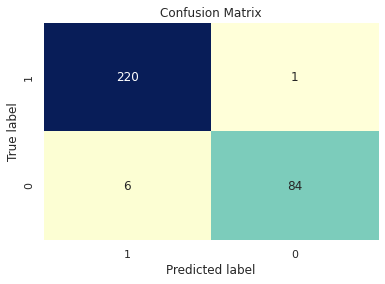

In [ ]:
def input_fn1(features, batch_size=256):
    """An input function for prediction."""
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

predictions = list(boosted_trees_est.predict(
    input_fn=lambda: input_fn1(itesting_set)))

predicted_labels = []
for i in range(0,len(predictions)):
  index = np.argmax(predictions[i]['probabilities'])
  predicted_labels.append(index)

labels = list(itesting_set_y)

def plot_confusion_matrix(true, pred):
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(true, pred, labels=[1, 0])

    import seaborn as sns; sns.set()
    import matplotlib.pyplot as plt

    cm_df = pd.DataFrame(confusion_matrix,
                 index = ['1', '0'], 
                 columns = ['1', '0'])
    ax = sns.heatmap(cm_df, fmt = 'd' , cmap="YlGnBu", cbar = False,  annot=True)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(labels,predicted_labels)


In [ ]:
#DNN classifier
dnn_est = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

dnn_est = tf.estimator.add_metrics(dnn_est, metrics_fn)

dnn_est.train(
    input_fn=lambda: input_fn(itraining_set, itraining_set_y, training=True),
    steps=500)

result = dnn_est.evaluate(input_fn=lambda: input_fn(itesting_set, itesting_set_y, training=False))

clear_output()

result

{'accuracy': 0.6688103,
 'accuracy_baseline': 0.7106109,
 'auc': 0.6121921,
 'auc_precision_recall': 0.8048754,
 'average_loss': 0.7734589,
 'false_negatives': 23.0,
 'false_positives': 80.0,
 'global_step': 500,
 'label/mean': 0.7106109,
 'loss': 0.7338333,
 'precision': 0.7122302,
 'prediction/mean': 0.811187,
 'recall': 0.8959276,
 'true_negatives': 10.0,
 'true_positives': 198.0}

In [ ]:
#linear classifier
linear_est = tf.estimator.LinearClassifier(my_feature_columns)
linear_est = tf.estimator.add_metrics(linear_est, metrics_fn)

linear_est.train(
    input_fn=lambda: input_fn(itraining_set, itraining_set_y, training=True),
    steps=10)
result = linear_est.evaluate(input_fn=lambda: input_fn(itesting_set, itesting_set_y, training=False))
clear_output()
result

{'accuracy': 0.67202574,
 'accuracy_baseline': 0.7106109,
 'auc': 0.6488688,
 'auc_precision_recall': 0.8091512,
 'average_loss': 1.2697825,
 'false_negatives': 32.0,
 'false_positives': 70.0,
 'global_step': 10,
 'label/mean': 0.7106109,
 'loss': 0.9533379,
 'precision': 0.7297297,
 'prediction/mean': 0.81094545,
 'recall': 0.8552036,
 'true_negatives': 20.0,
 'true_positives': 189.0}

In [ ]:
model = tf.keras.Sequential([
tf.keras.layers.Dense( 128 , input_shape=( 10 ,)),
tf.keras.layers.Dropout( 0.2 ),
tf.keras.layers.Dense( 1 , activation= 'sigmoid' ),
])

model.compile(optimizer=tf.keras.optimizers.Adam( 0.01 ),
loss=tf.keras.losses.BinaryCrossentropy(),
metrics=[ 'accuracy' ,
tf.keras.metrics.TruePositives(),
tf.keras.metrics.TrueNegatives(),
tf.keras.metrics.FalsePositives(),
tf.keras.metrics.FalseNegatives()])

model.fit(itraining_set, itraining_set_y, epochs= 200 )
clear_output()
results = model.evaluate(itesting_set, itesting_set_y)
print('accuracy ',results[1])
print('true positives ',results[2])
print('true negatives ',results[3])
print('false positives ',results[4])
print('false negatives ',results[5])

10/10 [==============================] - 0s 3ms/step - loss: 0.4908 - accuracy: 0.6913 - true_positives_12: 168.0000 - true_negatives_12: 47.0000 - false_positives_12: 43.0000 - false_negatives_12: 53.0000
accuracy  0.6913183331489563
true positives  168.0
true negatives  47.0
false positives  43.0
false negatives  53.0


In [ ]:
############ USELESS BUT DON'T WANT TO DELETE #######################################

 test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
      x={"x": np.array(itesting_set)},
      y=np.array(itesting_set_y),
      num_epochs=1,
      shuffle=True)
 
labels = list(itraining_set_y)
predictions = list(linear_est.predict(input_fn=test_input_fn))
confusion_matrix = tf.confusion_matrix(labels, predictions)

# Rebuild the input pipeline
input_fn = create_eval_input_fn(path=eval_files)
features, labels = input_fn()

# Rebuild the model
predictions = model_fn(features, labels, tf.estimator.ModeKeys.EVAL).predictions

# Manually load the latest checkpoint
saver = tf.train.Saver()
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('/my/directory')
    saver.restore(sess, ckpt.model_checkpoint_path)

    # Loop through the batches and store predictions and labels
    prediction_values = []
    label_values = []
    while True:
        try:
            preds, lbls = sess.run([predictions, labels])
            prediction_values += preds
            label_values += lbls
        except tf.errors.OutOfRangeError:
            break
    # store prediction_values and label_values somewhere

